# Gaussian Naive Bayes Classifier - Default Credit Card Dataset

Source
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

This dataset has both categorical and continuous variables.

If we just use a bayes classifier with a gaussian kernel without preparing the dataset before, the precision score will be very low (36% on average), because a gaussian kernel is not able to predict categorical variables very well.

To overcome this issue, we will combine 2 workarounds.
* 1- For each categorical variable, we will use pandas.get_dummies to create new binary dummy variables. For example, the categorical variable MARRIAGE of our dataset can take 3 values : {1,2,3}. pandas.get_dummies will erase the MARRIAGE variable and replace it by 3 dummies variables : MARRIAGE1, MARRIAGE2 and MARRIAGE3. Each one of those dummy variables is a binary one.
* 2- We will train two minors bayes classifiers. One with a gaussian kernel, who will be train on the continuous variables only. And one with a Bernoulli kernel (perfect for predicting the outcome of binary variables) who will be train on the variables left.

Here are the steps for the second workaround, in details :

- a) The dataset is divided into 3 subsets : training, final training and testing
- b) Minor bayes classifier with Bernoulli kernel is trained on the training subset using the dummy variables only
- c) Minor bayes classifier with Gaussian kernel is trained on the training subset using the continuous variables only
- d) Features needed for the final Bayes classifier training are extracted from the 2 minor classifiers, by predicting
    the probabilities on the final training subset
- e) Final bayes classifier with Gaussian kernel is trained on the predicted probabilities made by the 2 minor classifiers
     on the previous steps, and on the correspondind expected targets
- f) It is now time for testing. The features needed by the final bayes classifier are extracted from the 2 minor ones,
     using a prediction on the test subset
- g) The final bayes classifier made the final prediction based on the prediction of the 2 minors classifier

In [1]:
# Need to manually install the library to use SMOTE - only need to install it one time
# !pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\admin\appdata\local\enthought\canopy\user\lib\site-packages
Requirement already up-to-date: scipy in c:\users\admin\appdata\local\enthought\canopy\user\lib\site-packages (from imbalanced-learn)
Requirement already up-to-date: numpy in c:\users\admin\appdata\local\enthought\canopy\user\lib\site-packages (from imbalanced-learn)
Requirement already up-to-date: scikit-learn in c:\users\admin\appdata\local\enthought\canopy\user\lib\site-packages (from imbalanced-learn)


In [2]:
# LIBRARIES
%matplotlib inline
import numpy as np
import pandas
import itertools
import matplotlib.pyplot as plt
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score

# The manual installation of SMOTE with the pip command generates warning in each cells during execution
# This warning is the result of an issue within the kernel : https://github.com/jupyter/notebook/issues/2239
# At the moment, we will just ignore those warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
def prepare_fraud_datasets():
    trainVal = pandas.read_csv('Datasets/CC_fraud_TrainVal.csv')
    test = pandas.read_csv('Datasets/CC_fraud_Test.csv')    
    
    # Get target
    trainVal_target = trainVal['Class']
    test_target = test['Class']
    
    # Delete class column from non target set
    del trainVal['Class']
    del test['Class']

    return trainVal, trainVal_target, test, test_target

In [4]:
# UTILITIES FUNCTIONS

# First we train/fit the 2 minors bayes classifiers (Gaussian and Bernoulli) using the X_train and y_train sets
# Then, we get the predicted probabilities from them using X_train_final and y_train_final
# Those probs are the new 4 features used by the major bayes classifier (gaussian kernel) 
# which is train with those plus the y_train_final
# X_test goes first through the 2 minors classifiers to get the 4 features (predicted proba for each class from each classifier)
# Then those extracted features are used by the final bayes classifier to do the final prediction
# Which is compared with the expected result : y_test
# and allow us to estimate the accuracy and other metrics of the model efficiency
def train_test_and_display_result_from_bayes_classifier_with_minor_classifier(X_train, y_train, X_train_final, y_train_final, X_test, y_test):
    # Fit the Gaussian and Bernoulli bayes classifier, the first on continuous variables, the second one on dummy variables (binary)
    bernoulli_X_train = X_train[X_train.columns.difference(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])]
    gaussian_X_train = X_train[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
    bernoulli_X_train_final = X_train_final[X_train_final.columns.difference(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])]
    gaussian_X_train_final = X_train_final[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

    gaussian_NB = GaussianNB()
    bernoulli_NB = BernoulliNB()
    gaussian_NB.fit(gaussian_X_train, y_train)
    bernoulli_NB.fit(bernoulli_X_train, y_train)

    # Use the second training set to predict probabilities on a new dataset for the gaussian and bernoulli bayes classifier
    predic_proba_gaussian = gaussian_NB.predict_proba(gaussian_X_train_final)
    predic_proba_bernoulli = bernoulli_NB.predict_proba(bernoulli_X_train_final)

    # Create a new dataset which features are the predicted probabilities from the gaussian and bernoulli bayes classifier
    # This dataset has 4 features : the prediction of the class 0 from the gaussian and bernoulli and the prediction of class 1 from both too
    df_gaussian_prediction = pandas.DataFrame(predic_proba_gaussian, columns=['gaussian_0_prediction', 'gaussian_1_prediction'])
    df_bernoulli_prediction = pandas.DataFrame(predic_proba_bernoulli, columns=['bernoulli_0_prediction', 'bernoulli_1_prediction'])

    df_gaussian_and_bernoulli_prediction = pandas.DataFrame(df_gaussian_prediction)
    df_gaussian_and_bernoulli_prediction['bernoulli_0_prediction'] = df_bernoulli_prediction['bernoulli_0_prediction']
    df_gaussian_and_bernoulli_prediction['bernoulli_1_prediction'] = df_bernoulli_prediction['bernoulli_1_prediction']

    # At the end, a new bayes classifier with a gaussian kernel is train on the newly created dataset with the 4 features
    final_gaussian_NB = GaussianNB()
    final_gaussian_NB.fit(df_gaussian_and_bernoulli_prediction, y_train_final)

    # Now we're testing the final classifier with the data from the test set.
    # First we need to get the value for the 4 features by doing a prediction with the 2 smaller gaussian classifier
    bernoulli_final_test = X_test[X_train.columns.difference(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])]
    gaussian_final_test = X_test[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

    # predicted probabilities on the test dataset from the gaussian and bernoulli bayes classifier
    predic_proba_gaussian_final = gaussian_NB.predict_proba(gaussian_final_test)
    predic_proba_bernoulli_final = bernoulli_NB.predict_proba(bernoulli_final_test)

    # convert the nparray into DataFrame
    df_gaussian_prediction_final = pandas.DataFrame(predic_proba_gaussian_final, columns=['gaussian_0_prediction', 'gaussian_1_prediction'])
    df_bernoulli_prediction_final = pandas.DataFrame(predic_proba_bernoulli_final, columns=['bernoulli_0_prediction', 'bernoulli_1_prediction'])

    # Experimentation
    # Before using the final gaussian bayes classifier, by curiosity, we want to check which accuracy we can obtain by simply
    # adding for each test input, the probabilities calculated by the bernoulli and the gaussian bayes classifier (and then dividing
    # the result by two) and see if it could be more accurate than the final gaussian bayes classifier
    added_proba_class_0 = df_gaussian_prediction_final['gaussian_0_prediction'] + df_bernoulli_prediction_final['bernoulli_0_prediction']
    added_proba_class_1 = df_gaussian_prediction_final['gaussian_1_prediction'] + df_bernoulli_prediction_final['bernoulli_1_prediction']

    y_predicted_by_hand = added_proba_class_0 > added_proba_class_1
    # Note: need to use this trick to get int at the end (otherwise 0 and 1 are converted to boolean automatically)
    y_predicted_by_hand[y_predicted_by_hand==True] = 'no_default'
    y_predicted_by_hand[y_predicted_by_hand==False] = 'default'
    y_predicted_by_hand[y_predicted_by_hand=='no_default'] = 0
    y_predicted_by_hand[y_predicted_by_hand=='default'] = 1

    # Get the accuracy rate for the experimentation method
    count = len([1 for idx, label in enumerate(y_test) if label == y_predicted_by_hand[idx]])
    print "Accuracy Rate, which is calculated manually is: %f" % ((float(count) / len(y_test)) * 100)

    # From here we continue our prediction with the final gaussian bayes classifier
    df_gaussian_and_bernoulli_prediction_final = pandas.DataFrame(df_gaussian_prediction_final)
    df_gaussian_and_bernoulli_prediction_final['bernoulli_0_prediction'] = df_bernoulli_prediction_final['bernoulli_0_prediction']
    df_gaussian_and_bernoulli_prediction_final['bernoulli_1_prediction'] = df_bernoulli_prediction_final['bernoulli_1_prediction']

    y_predicted = final_gaussian_NB.predict(df_gaussian_and_bernoulli_prediction_final)
    
    display_result(y_test, y_predicted, ['No default payment', 'Default payment'])

def train_test_display_result_bayes_classifier(X_train, y_train, X_test, y_test):
    gaussian_NB = GaussianNB()
    gaussian_NB.fit(X_train, y_train)
    y_predicted = gaussian_NB.predict(X_test)
    display_result(y_test, y_predicted, ['No fraudulent payment', 'Fraudulent payment'])
    

# Display all the metrics for a classifier efficiency
def display_result(y_test, y_predicted, classes_names):
    # Accuracy
    print "Accuracy Rate, for the final gaussian bayes classifier", accuracy_score(y_test, y_predicted) * 100

    # Null accuracy
    print "Null Accuracy for the test dataset", max(y_test.mean(), 1-y_test.mean()) * 100

    # F1 score
    print "F1 score is ", f1_score(y_test, y_predicted) * 100, "%"

    # Kapp (Cohen's kappa : classification accuracy normalized by the imbalance of the classes in the data)
    print "Cohen's kappa score is ", cohen_kappa_score(y_test, y_predicted) * 100, "%"

    # Confusion Matrix
    confustion_matrix_result = confusion_matrix(y_test, y_predicted)
    plot_confusion_matrix(confustion_matrix_result, classes=classes_names, normalize=False, title='Gaussian NB confusion matrix')
    plt.show()

    # Roc curve and AUC for Sensitivity (Recall) and Specificity
    plot_roc_curve_and_auc(y_test, y_predicted)
    
    # Roc curve and AUC for Precision and Recall
    plot_roc_curve_and_auc_precision_recall(y_test, y_predicted)


# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the Specificity/Sensitivity ROC and AUC curves
def plot_roc_curve_and_auc(y_test, y_predicted):
    fpr, tpr, threshold = roc_curve(y_test, y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (Specificity)')
    plt.show()
    
    
# Plot the Precision/Recall ROC and AUC curves
def plot_roc_curve_and_auc_precision_recall(y_test, y_predicted):
    average_precision = average_precision_score(y_test, y_predicted)
    precision, recall, _ = precision_recall_curve(y_test, y_predicted)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

In [65]:
# IMPORT DATASET AND DISPLAY INFORMATIONS
data = pandas.read_csv('UCI_Credit_Card.csv')

# Display name of each features, the type , the number and if there is null value
print('---------------------')
data.info()
data.describe()
print('---------------------')

# The dataset is clean : no null value

---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-nul

In [66]:
# CREATE DUMMY VARIABLES FOR CATEGORICAL VARIABLES

# Delete id column : we will not need it
del data['ID']

# Create dummy variables for categorical data.
# Example : SEX can take the value 1 or 2. We create two dummy variables SEX1 and SEX2 who can take the value 0 or 1
data_with_dummies = pandas.get_dummies(data, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

Accuracy Rate, which is calculated manually is: 79.216667
Accuracy Rate, for the final gaussian bayes classifier 77.9666666667
Null Accuracy for the test dataset 77.5166666667
F1 score is  48.197492163 %
Cohen's kappa score is  34.2632285308 %


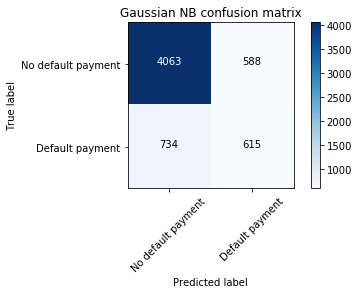

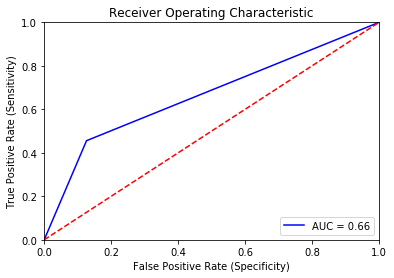

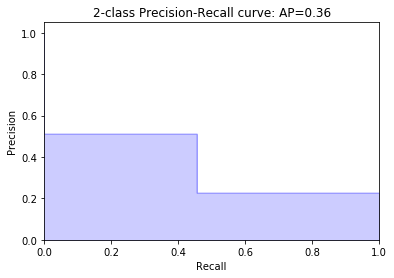

In [67]:
# TESTING AND TRAINING ON ORIGINAL AND UNALTERED DATASET

# NOTE : because of the dummy variables, for the Bayes Classifier, on the fraud dataset only, we will not use the same
# training and testing sets used by the other algorithms

# Separate the data for train and testing purposes
X_train_and_train_final, X_test, y_train_and_train_final, y_test = train_test_split(data_with_dummies[data_with_dummies.columns.difference(['default.payment.next.month'])], data_with_dummies['default.payment.next.month'], test_size = 0.20)
X_train, X_train_final, y_train, y_train_final = train_test_split(X_train_and_train_final, y_train_and_train_final, test_size = 0.20)

train_test_and_display_result_from_bayes_classifier_with_minor_classifier(X_train, y_train, X_train_final, y_train_final, X_test, y_test)

6636
Percentage of entries with default payment in new dataset :  50.0 %
Percentage of entries with non-default payment in new dataset :  50.0 %
Accuracy Rate, which is calculated manually is: 70.018832
Accuracy Rate, for the final gaussian bayes classifier 69.4538606403
Null Accuracy for the test dataset 50.1694915254
F1 score is  66.3625051846 %
Cohen's kappa score is  38.9464631591 %


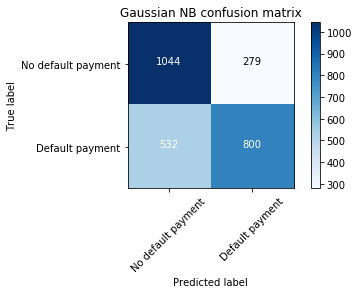

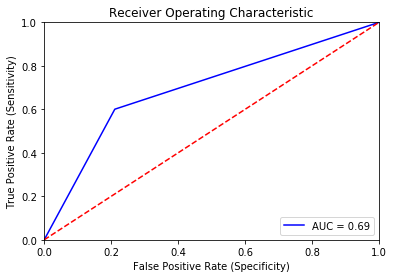

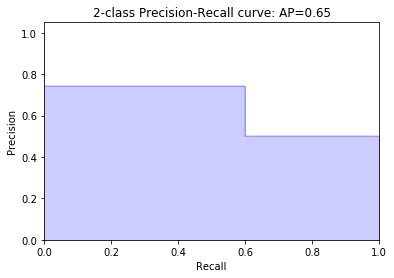

In [68]:
# TESTING AND TRAINING ON RANDOMLY UNDERSAMPLED DATA USING PANDAS AND DATAFRAME FUNCTIONALITIES

warnings.simplefilter('ignore')

number_of_default_payment = sum(data_with_dummies['default.payment.next.month'] == 1)
print number_of_default_payment

# index of all the non default payment entries in the data set
non_default_payment_indice = data_with_dummies[data_with_dummies['default.payment.next.month'] == 0].index

# index of the non default payment we will keep, choosen randomly
random_index_of_non_default_payment = np.random.choice(non_default_payment_indice, number_of_default_payment, replace=False)

# add the default payment to the new dataframe
df_undersampled_with_dummies = data_with_dummies[data_with_dummies['default.payment.next.month'] == 1]

# add the non default payment to the new data frame
df_undersampled_with_dummies = df_undersampled_with_dummies.append(data_with_dummies.iloc[random_index_of_non_default_payment], ignore_index=True)

# The dataset is now balanced, 50-50 default and non default payment entries
print 'Percentage of entries with default payment in new dataset : ', (float(sum(df_undersampled_with_dummies['default.payment.next.month'] == 1)) / len(df_undersampled_with_dummies)) * 100, '%'
print 'Percentage of entries with non-default payment in new dataset : ', (float(sum(df_undersampled_with_dummies['default.payment.next.month'] == 0)) / len(df_undersampled_with_dummies)) * 100, '%'

# Separate the data for train and testing purposes
X_train_and_train_final, X_test, y_train_and_train_final, y_test = train_test_split(df_undersampled_with_dummies[df_undersampled_with_dummies.columns.difference(['default.payment.next.month'])], df_undersampled_with_dummies['default.payment.next.month'], test_size = 0.20)
X_train, X_train_final, y_train, y_train_final = train_test_split(X_train_and_train_final, y_train_and_train_final, test_size = 0.20)

train_test_and_display_result_from_bayes_classifier_with_minor_classifier(X_train, y_train, X_train_final, y_train_final, X_test, y_test)

Accuracy Rate, which is calculated manually is: 70.546139
Accuracy Rate, for the final gaussian bayes classifier 70.3578154426
Null Accuracy for the test dataset 51.9774011299
F1 score is  65.945478148 %
Cohen's kappa score is  40.1962846729 %


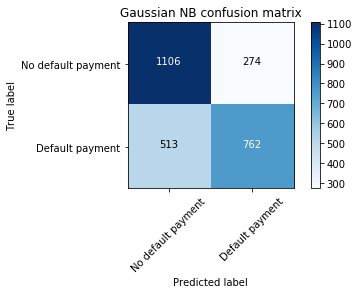

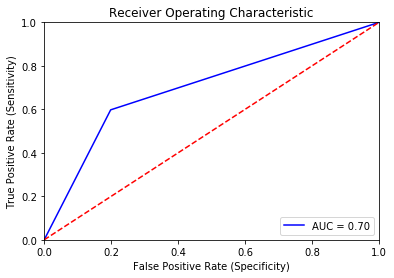

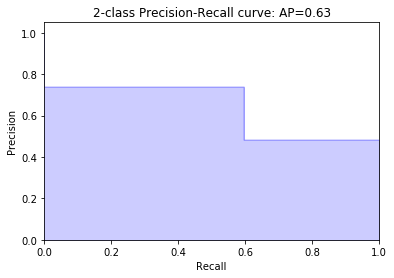

C:\Users\Admin\AppData\Local\Enthought\Canopy\App\appdata\canopy-1.7.4.3348.win-x86_64\lib\json\encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-12-22 13:34:53.469000. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [69]:
# TESTING AND TRAINING ON OVERSAMPLED DATA USING SMOTE

X_train_and_train_final, X_test, y_train_and_train_final, y_test = train_test_split(df_undersampled_with_dummies[df_undersampled_with_dummies.columns.difference(['default.payment.next.month'])], df_undersampled_with_dummies['default.payment.next.month'], test_size = 0.20)
X_train, X_train_final, y_train, y_train_final = train_test_split(X_train_and_train_final, y_train_and_train_final, test_size = 0.20)

sm = SMOTE()
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
X_train_final_SMOTE, y_train_final_SMOTE = sm.fit_sample(X_train_final, y_train_final)

# convert ndarray into data frame
X_train_SMOTE = pandas.DataFrame(X_train_SMOTE, columns=X_train.columns.values)
y_train_SMOTE = pandas.DataFrame(y_train_SMOTE)
X_train_final_SMOTE = pandas.DataFrame(X_train_final_SMOTE, columns=X_train_final.columns.values)
y_train_final_SMOTE = pandas.DataFrame(y_train_final_SMOTE)

train_test_and_display_result_from_bayes_classifier_with_minor_classifier(X_train_SMOTE, y_train_SMOTE, X_train_final_SMOTE, y_train_final_SMOTE, X_test, y_test)

# Gaussian Naive Bayes Classifier - Fraud Credit Card Dataset

Source
https://www.kaggle.com/dalpozz/creditcardfraud

The features in this dataset have already been transformed with PCA.
All the features are of type float and are continuous.
Due to confidentality issue, it is not possible to retrieve the real value of the features before the PCA operation.

Only 2 features were not changed with PCA : Time and Amount
Time : time between two transactions
Amount : amount for the payment

Class : 1 is a fraudulent payment and 0 is not

It is not necessary, as we did for the first dataset, to use 2 minor Bayes classifier.
As each features can be interpreted to be of Gaussian distribution, we will directly use a Bayes Classifier with a gaussian kernel.

In [8]:
# IMPORT DATASET AND DISPLAY INFORMATIONS
data2 = pandas.read_csv('creditcard.csv')

# Display name of each features, the type , the number and if there is null value
print('---------------------')
data2.info()
data2.describe()
print('---------------------')

# The dataset is clean : no null value

---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 

C:\Users\Admin\AppData\Local\Enthought\Canopy\App\appdata\canopy-1.7.4.3348.win-x86_64\lib\json\encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-12-21 21:41:01.803000. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Accuracy Rate, for the final gaussian bayes classifier 99.288999684
Null Accuracy for the test dataset 99.8191776974
F1 score is  26.2295081967 %
Cohen's kappa score is  26.0121354978 %


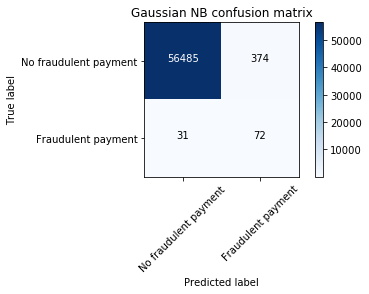

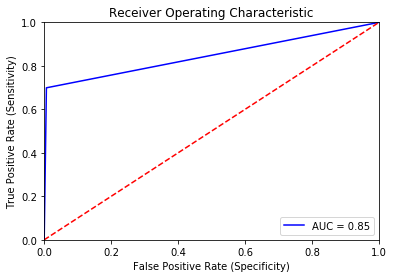

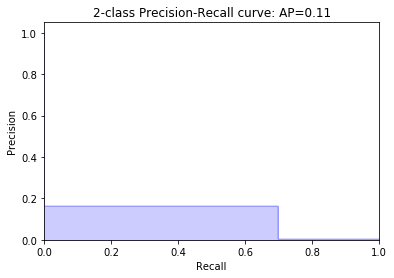

In [13]:
# TESTING AND TRAINING ON ORIGINAL AND UNALTERED DATASET

# Separate the data for train and testing purposes
X_train, y_train, X_test, y_test = prepare_fraud_datasets()

train_test_display_result_bayes_classifier(X_train, y_train, X_test, y_test)

Accuracy Rate, for the final gaussian bayes classifier 98.6394438398
Null Accuracy for the test dataset 99.8191776974
F1 score is  16.5769644779 %
Cohen's kappa score is  16.3078537385 %


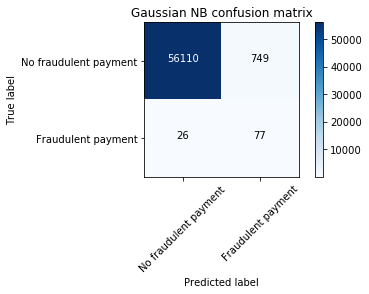

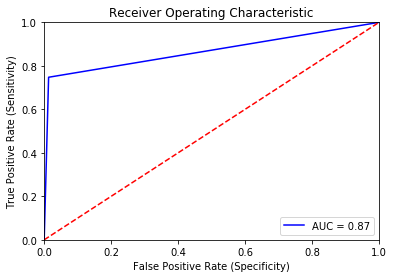

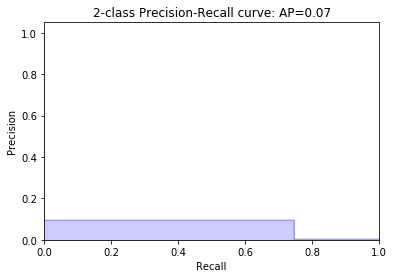

In [72]:
# TRAINING ON RANDOMLY UNDERSAMPLED DATA USING PANDAS AND DATAFRAME FUNCTIONALITIES

warnings.simplefilter('ignore')

X_train, y_train, X_test, y_test = prepare_fraud_datasets()
X_train = pandas.read_csv('Datasets/Undersampled/CC_fraud_TrainVal_undersampled.csv')
y_train = pandas.read_csv('Datasets/Undersampled/CC_fraud_TrainVal_target_undersampled.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)

train_test_display_result_bayes_classifier(X_train, y_train, X_test, y_test)

Accuracy Rate, for the final gaussian bayes classifier 99.2328218813
Null Accuracy for the test dataset 99.8191776974
F1 score is  27.2878535774 %
Cohen's kappa score is  27.0693053886 %


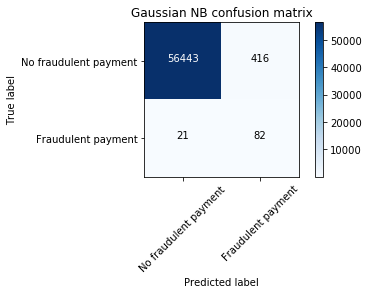

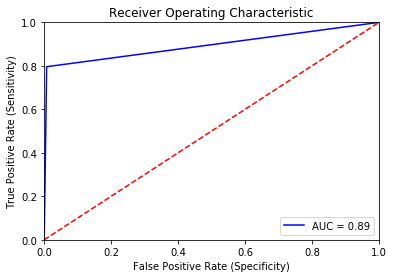

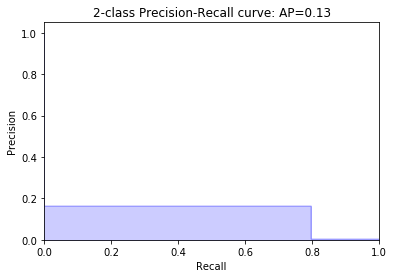

In [63]:
# TESTING AND TRAINING ON OVERSAMPLED DATA USING SMOTE

X_train, y_train, X_test, y_test = prepare_fraud_datasets()
X_train = pandas.read_csv('Datasets/SMOTE/CC_fraud_TrainVal_SMOTE.csv')
y_train = pandas.read_csv('Datasets/SMOTE/CC_fraud_TrainVal_target_SMOTE.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)

train_test_display_result_bayes_classifier(X_train, y_train, X_test, y_test)

In [19]:
# CREATION OF CSV FILE LOGIC (to ensure that for every Classifier, we have the same training-validating-testing sets)

def prepare_fraud_train_and_trainVal_datasets():
    trainVal = pandas.read_csv('Datasets/CC_fraud_TrainVal.csv')
    train = pandas.read_csv('Datasets/CC_fraud_Train.csv')    
    
    # Get target
    trainVal_target = trainVal['Class']
    train_target = train['Class']
    
    # Delete class column from non target set
    del trainVal['Class']
    del train['Class']

    return trainVal, trainVal_target, train, train_target

def prepare_default_train_and_trainVal_datasets():
    trainVal = pandas.read_csv('Datasets/CC_default_TrainVal.csv')
    train = pandas.read_csv('Datasets/CC_default_Train.csv')    
    
    # Get target
    trainVal_target = trainVal['default.payment.next.month']
    train_target = train['default.payment.next.month']
    
    # Delete class column from non target set
    del trainVal['ID']
    del train['ID']
    del trainVal['default.payment.next.month']
    del train['default.payment.next.month']

    return trainVal, trainVal_target, train, train_target

def create_undersampled_SMOTE_csv_file(X_train, y_train, X_trainVal, y_trainVal, arrayOfFileName):
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
    X_trainVal_SMOTE, y_trainVal_SMOTE = sm.fit_sample(X_trainVal, y_trainVal)

    # convert ndarray into data frame
    X_train_SMOTE = pandas.DataFrame(X_train_SMOTE, columns=X_train.columns.values)
    y_train_SMOTE = pandas.DataFrame(y_train_SMOTE)

    X_trainVal_SMOTE = pandas.DataFrame(X_trainVal_SMOTE, columns=X_train.columns.values)
    y_trainVal_SMOTE = pandas.DataFrame(y_trainVal_SMOTE)
    
    X_train_SMOTE.to_csv(arrayOfFileName[0])
    y_train_SMOTE.to_csv(arrayOfFileName[1])
    X_trainVal_SMOTE.to_csv(arrayOfFileName[2])
    y_trainVal_SMOTE.to_csv(arrayOfFileName[3])


    # Undersampled train and trainVal datasets for Fraud dataset

    # Make the train set balanced
    number_of_fraud_payment = sum(y_train == 1)

    # index of all the non fraudulent payment entries in the data set
    non_fraudulent_payment_indice = y_train[y_train == 0].index

    # index of all the fraudulent payment entries in the data set
    fraudulent_payment_indice = y_train[y_train == 1].index

    # index of the non fraudulent payment we will keep, choosen randomly
    random_index_of_non_fraudulent_payment = np.random.choice(non_fraudulent_payment_indice, number_of_fraud_payment, replace=False)

    # add the fraudulent payment to the new dataframe
    y_train_undersampled = y_train[y_train == 1]
    X_train_undersampled = X_train.iloc[fraudulent_payment_indice]

    # add the non fraudulent payment to the new data frame
    y_train_undersampled = y_train_undersampled.append(y_train.iloc[random_index_of_non_fraudulent_payment], ignore_index=True)
    X_train_undersampled = X_train_undersampled.append(X_train.iloc[random_index_of_non_fraudulent_payment], ignore_index=True)
    y_train_undersampled = pandas.DataFrame(y_train_undersampled, columns=['Class'])
    
    X_train_undersampled.to_csv(arrayOfFileName[4])
    y_train_undersampled.to_csv(arrayOfFileName[5])

    
    # Make the trainVal set balanced
    number_of_fraud_payment = sum(y_trainVal == 1)

    # index of all the non fraudulent payment entries in the data set
    non_fraudulent_payment_indice = y_trainVal[y_trainVal == 0].index

    # index of all the fraudulent payment entries in the data set
    fraudulent_payment_indice = y_trainVal[y_trainVal == 1].index

    # index of the non fraudulent payment we will keep, choosen randomly
    random_index_of_non_fraudulent_payment = np.random.choice(non_fraudulent_payment_indice, number_of_fraud_payment, replace=False)
    # add the fraudulent payment to the new dataframe
    y_trainVal_undersampled = y_trainVal[y_trainVal == 1]
    X_trainVal_undersampled = X_trainVal.iloc[fraudulent_payment_indice]
    # add the non fraudulent payment to the new data frame
    y_trainVal_undersampled = y_trainVal_undersampled.append(y_trainVal.iloc[random_index_of_non_fraudulent_payment], ignore_index=True)
    X_trainVal_undersampled = X_trainVal_undersampled.append(X_trainVal.iloc[random_index_of_non_fraudulent_payment], ignore_index=True)
    y_trainVal_undersampled = pandas.DataFrame(y_trainVal_undersampled, columns=['Class'])
    X_trainVal_undersampled.to_csv(arrayOfFileName[6])
    y_trainVal_undersampled.to_csv(arrayOfFileName[7])  
    
    
# SMOTE train and trainVal datasets for Default dataset
X_train, y_train, X_trainVal, y_trainVal = prepare_default_train_and_trainVal_datasets()
defaultFileNames = ["CC_default_Train_SMOTE.csv", "CC_default_Train_target_SMOTE.csv", "CC_default_TrainVal_SMOTE.csv", "CC_default_TrainVal_target_SMOTE.csv", "CC_default_Train_undersampled.csv", "CC_default_Train_target_undersampled.csv", "CC_default_TrainVal_undersampled.csv", "CC_default_TrainVal_target_undersampled.csv"]
create_undersampled_SMOTE_csv_file(X_train, y_train, X_trainVal, y_trainVal, defaultFileNames)    
    
# # SMOTE train and trainVal datasets for Fraud dataset
X_train, y_train, X_trainVal, y_trainVal = prepare_fraud_train_and_trainVal_datasets()
fraudFileNames = ["CC_fraud_Train_SMOTE.csv", "CC_fraud_Train_target_SMOTE.csv", "CC_fraud_TrainVal_SMOTE.csv", "CC_fraud_TrainVal_target_SMOTE.csv", "CC_fraud_Train_undersampled.csv", "CC_fraud_Train_target_undersampled.csv", "CC_fraud_TrainVal_undersampled.csv", "CC_fraud_TrainVal_target_undersampled.csv"]
create_undersampled_SMOTE_csv_file(X_train, y_train, X_trainVal, y_trainVal, fraudFileNames)


3998
3998
3998
3998
7996
7996
287
287
287
287
574
574


C:\Users\Admin\AppData\Local\Enthought\Canopy\App\appdata\canopy-1.7.4.3348.win-x86_64\lib\json\encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-12-22 12:54:39.938000. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
